In [1]:
!echo "Last updated: `date`"

Last updated: Fri Aug  7 17:50:38 PDT 2020


In [2]:
import json
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
import numpy as onp

import sys
sys.path.append('../util')
import gp_plot_util

In [3]:
# One-dimensional squared exponential kernel with diagonal noise term.
def squared_exp_cov_1D(X, variance, lengthscale):
    deltaXsq = np.power((X[:, None] - X) / lengthscale, 2.0)
    K = variance * np.exp(-0.5 * deltaXsq)
    return K

# GP model.
def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    variance = numpyro.sample("kernel_var", dist.LogNormal(0.0, 0.1))
    lengthscale = numpyro.sample("kernel_length", dist.LogNormal(0.0, 1.0))
    sigma = numpyro.sample("sigma", dist.LogNormal(0.0, 1.0))

    # Compute kernel
    K = squared_exp_cov_1D(X, variance, lengthscale)
    K += np.eye(X.shape[0]) * np.power(sigma, 2)

    # Sample y according to the standard gaussian process formula
    numpyro.sample("y", dist.MultivariateNormal(loc=np.zeros(X.shape[0]),
                                                covariance_matrix=K), obs=y)

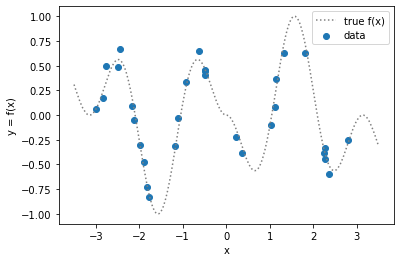

In [4]:
# Read data.
path_to_data = '../data/gp-data-N30.json'
simdata = json.load(open(path_to_data))

# Store data as torch.tensors.
X = np.array(simdata['x'])
y = np.array(simdata['y'])
x_grid = np.array(simdata['x_grid'])
f = np.array(simdata['f'])

# Plot data and true function.
plt.scatter(X, y, label='data')
plt.plot(x_grid, f, ls=':', c='grey', label='true f(x)')
plt.xlabel('x')
plt.ylabel('y = f(x)')
plt.legend();

In [5]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size
kernel = HMC(GP, step_size=.01, trajectory_length=1,
             adapt_step_size=False, adapt_mass_matrix=False)

hmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
hmc.run(rng_key, X, y)

hmc_samples = hmc.get_samples()
hmc_samples = dict(alpha=np.sqrt(hmc_samples['kernel_var']), rho=hmc_samples['kernel_length'],
                   sigma=hmc_samples['sigma'])

sample: 100%|██████████| 2000/2000 [00:17<00:00, 112.41it/s, 100 steps of size 1.00e-02. acc. prob=1.00]


CPU times: user 44.3 s, sys: 25.8 s, total: 1min 10s
Wall time: 20.4 s


In [6]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(GP, max_tree_depth=10, target_accept_prob=0.8)

nuts = MCMC(kernel, num_samples=1000, num_warmup=1000)
nuts.run(rng_key, X, y)

nuts_samples = hmc.get_samples()
nuts_samples = dict(alpha=np.sqrt(nuts_samples['kernel_var']), rho=nuts_samples['kernel_length'],
                    sigma=nuts_samples['sigma'])

sample: 100%|██████████| 2000/2000 [00:09<00:00, 214.24it/s, 3 steps of size 6.31e-01. acc. prob=0.93]


CPU times: user 15.2 s, sys: 6.76 s, total: 22 s
Wall time: 10.6 s


../util/gp_plot_util.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu, S)


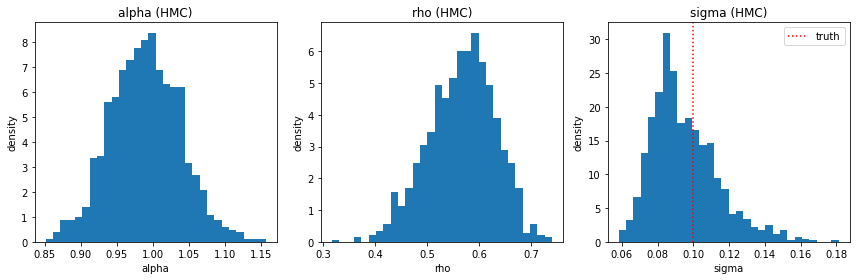

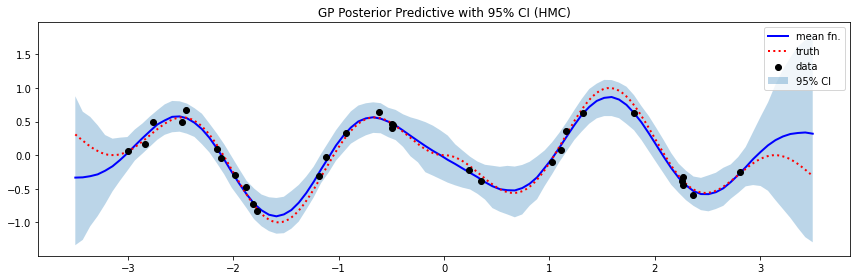

In [7]:
# Plot posterior for HMC
gp_plot_util.make_plots(hmc_samples, suffix="HMC",
                        x=X, y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])

../util/gp_plot_util.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mu, S)


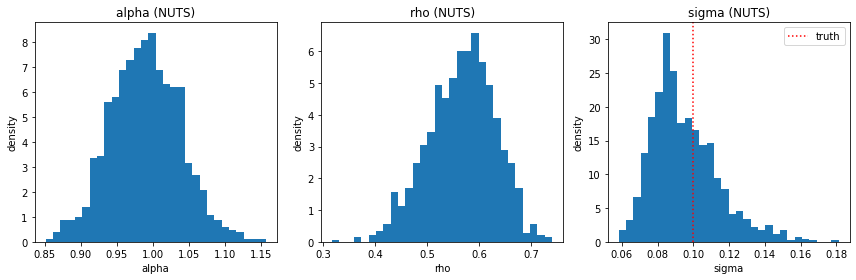

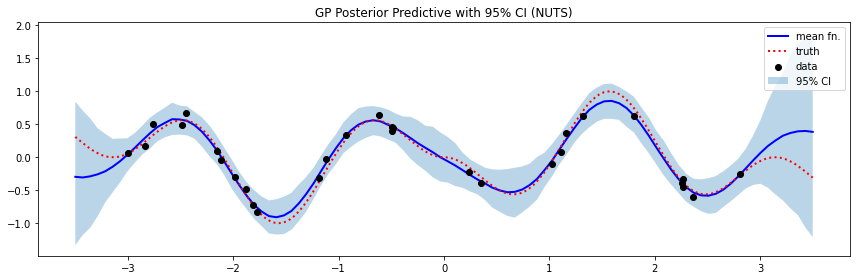

In [8]:
# Plot posterior for NUTS
gp_plot_util.make_plots(hmc_samples, suffix="NUTS",
                        x=X, y=y, x_grid=x_grid, f=f, sigma_true=simdata['sigma'])